# Lab 4

    - Jeffrey Taylor
    - Austin Hayden
    - Riley Galante
    - Eric Bernard

***
> _Predict, for each county, what the child poverty rate will be. You will need to convert this from regression to four levels of classification by quantizing the variable of interest._

## Load, Split, and Balance

In [1]:
# [.5 points] 
# 1 - Load the data into memory and save it to a pandas data frame.
#     Do not normalize or one-hot encode any of the features until asked to do so.

import pandas as pd

df = pd.read_csv('acs2017_census_tract_data.csv')


In [2]:
# 2 - Remove any observations that having missing data. Encode any string data as 
#     integers for now...
from sklearn.preprocessing import LabelEncoder

df = df.dropna()

d_pass = {}
for col in df.columns:
    if df[col].dtype == 'object':
        d_pass[col] = LabelEncoder()
        df[col] = d_pass[col].fit_transform(df[col])


In [3]:
# [.5 points] 
# Balance the dataset so that about the same number
# of instances are within each class. Choose a method for 
# balancing the dataset and explain your reasoning for selecting 
# this method. One option is to choose quantization thresholds for
# the "ChildPoverty" variable that equally divide the data into
# four classes. Should balancing of the dataset be done for both
# the training and testing set? Explain.
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit

q1 = df.ChildPoverty.quantile(.25)
q2 = df.ChildPoverty.quantile(.5)
q3 = df.ChildPoverty.quantile(.75)

df.ChildPoverty[df.ChildPoverty < q1] = 0
df.ChildPoverty[(df.ChildPoverty < q2) & (df.ChildPoverty >= q1)] = 1
df.ChildPoverty[(df.ChildPoverty < q3) & (df.ChildPoverty >= q2)] = 2
df.ChildPoverty[df.ChildPoverty >= q3] = 3

y = df['ChildPoverty'].values.astype(np.int)
del df['ChildPoverty']
del df['County']

X = df.to_numpy()

X_train = X
y_train = y
X_test = X
y_test = y


<ipython-input-3-8b144d29ea01>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.ChildPoverty[df.ChildPoverty < q1] = 0
<ipython-input-3-8b144d29ea01>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.ChildPoverty[(df.ChildPoverty < q2) & (df.ChildPoverty >= q1)] = 1
<ipython-input-3-8b144d29ea01>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.ChildPoverty[(df.ChildPoverty < q3) & (df.ChildPoverty >= q2)] = 2
<ipython-input

In [4]:
# [.5 points]
# Assume you are equally interested in the 
# classification performance for each class in the dataset. 
# Split the dataset into 80% for training and 20% for testing.
cv = ShuffleSplit(n_splits=1,test_size=0.2)

for temp_train_index, temp_test_index in cv.split(X, y):
    train_index = temp_train_index
    test_index = temp_test_index

X_train = X[train_index]
y_train = y[train_index]

X_test = X[test_index]
y_test = y[test_index]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(58174, 35)
(58174,)
(14544, 35)
(14544,)


We decided to use the quantile function provided by pandas to balance the dataset. This was primarily because it is a very simple method and is effective for large datasets like this one. Balancing of the dataset should not be done with both training and testing. Doing this would incorporate the biases of the testing classes with the training boundaries, which removes the point of having a separate set of data to test the model on. Thus, balancing should just be done on the training data for the construction of the model.

## Pre-Processing
There are a number of version of the two layer perceptron covered in class. When using the example two layer network from class be sure that you use: (1) vectorized computation, (2) mini-batching, and (3) proper Glorot initialization, at a minimum.  

In [5]:
# [.5 points]
# Use the example two-layer perceptron network from 
# the class example and quantify performance using accuracy. 
# Do not normalize or one-hot encode the data (not yet).
# Be sure that training converges by graphing the loss function versus 
# the number of epochs. 


# Example adapted from addaptation of
#     https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
#     Original Author: Sebastian Raschka
from scipy.special import expit
import sys

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30, C=0.0, 
                 epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    

In [6]:
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # backpropagation
        grad1 = np.zeros(W1.shape)
        grad2 = np.zeros(W2.shape)
        
        # for each instance's activations 
        for (a1,a2,a3,y) in zip(A1.T,A2.T,A3.T,Y_enc.T):
            dJ_dz2 = -2*(y - a3)*a3*(1-a3)
            dJ_dz1 = dJ_dz2 @ W2 @ np.diag(a2*(1-a2))
                         
            grad2 += dJ_dz2[:,np.newaxis]  @ a2[np.newaxis,:]
            grad1 += dJ_dz1[1:,np.newaxis] @ a1[np.newaxis,:] 
            # don't incorporate bias term in the z1 gradient 
            # (its added in a2 from another layer)
            

        # regularize weights that are not bias terms
        grad1[:, 1:] += (W1[:, 1:] * self.l2_C)
        grad2[:, 1:] += (W2[:, 1:] * self.l2_C)

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data,self.W1,self.W2)
            
            cost = self._cost(A3,Y_enc,self.W1,self.W2)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Y_enc=Y_enc,
                                              W1=self.W1, W2=self.W2)

            self.W1 -= self.eta * grad1
            self.W2 -= self.eta * grad2
            

        return self
    

In [7]:
class TwoLayerPerceptronVectorized(TwoLayerPerceptron):
    # just need a different gradient calculation
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2

In [8]:
class TLPVectorizedMiniBatch(TwoLayerPerceptronVectorized):
    def __init__(self, alpha=0.1, decrease_const=0.0, shuffle=True, minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    def fit(self, X, y, print_progress=0):
        """ Learn weights from training data."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()
        
        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum

        self.cost_ = []
        self.score_ = []
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        
        for i in range(self.epochs):

            # adaptive learning rate
            eta = self.eta / (1 + self.decrease_const*i) # decreasing learning rate
            # there are many forms of adaptive learning rates out there!

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            # use numpy split to split into equal sized batches 
            # num batches== self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1, W2=self.W2)

                rho_W1, rho_W2 = eta * grad1, eta * grad2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
        return self

In [9]:
class TLPBetterInitial(TLPVectorizedMiniBatch):             
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        return W1, W2

In [10]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

def print_result(nn,X_train,y_train,X_test,y_test,title="",color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

Epoch: 50/50

Cross Entropy Loss :
Resubstitution acc: 0.24799738714889813
Validation acc: 0.24697469746974698


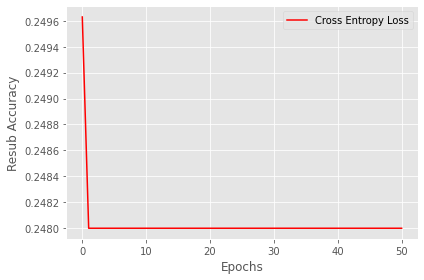

CPU times: user 43.4 s, sys: 3.76 s, total: 47.2 s
Wall time: 11.8 s


In [11]:
%%time 
prm = dict(n_hidden=100, 
              C=0.1, # tradeoff L2 regularizer
              epochs=50, # iterations
              eta=0.001,  # learning rate
              random_state=1)

nn = TLPBetterInitial(**prm)
nn.fit(X_train, y_train, print_progress=1)
print_result(nn,X_train,y_train,X_test,y_test,title="Cross Entropy Loss",color="red")

In [12]:
# [.5 points]
# Now normalize the continuous numeric feature data. 
# Use the example two-layer perceptron network from the class 
# example and quantify performance using accuracy. Be sure that
# training converges by graphing the loss function versus the 
# number of epochs.  

# So we'll use the ordinally encoded strings here and normalize
#         https://www.journaldev.com/45109/normalize-data-in-python

from sklearn.preprocessing import StandardScaler

df = pd.DataFrame(StandardScaler().fit(df).transform(df), columns=df.columns)
norm = df.to_numpy()

X_train = norm[train_index]
X_test = norm[test_index]

prm = dict(n_hidden=100, 
              C=0.1, # tradeoff L2 regularizer
              epochs=100, # iterations
              eta=0.001,  # learning rate
              random_state=1)

Epoch: 100/100

Cross Entropy Loss :
Resubstitution acc: 0.41454945508302676
Validation acc: 0.41804180418041803


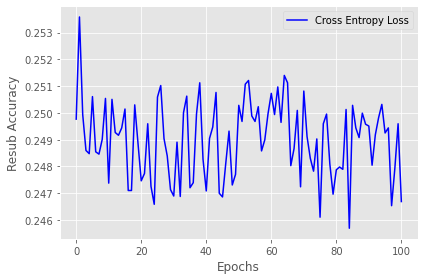

CPU times: user 1min 40s, sys: 7.14 s, total: 1min 47s
Wall time: 27 s


In [13]:
%%time 
nn_norm = TLPBetterInitial(**prm)
nn_norm.fit(X_train, y_train, print_progress=1)
print_result(nn_norm,X_train,y_train,X_test,y_test,title="Cross Entropy Loss",color="blue")

In [14]:
# [.5 points]
# Now normalize the continuous numeric feature data
# AND one hot encode the categorical data. Use the example 
# two-layer perceptron network from the class example and quantify
# performance using accuracy. Be sure that training converges 
# by graphing the loss function versus the number of epochs. 
df_onehot = pd.get_dummies(df.State,prefix='State')
df = pd.concat((df,df_onehot),axis=1)
del df['State']

onehot = df.to_numpy();

X_train = onehot[train_index];
X_test = onehot[test_index];

prm = dict(n_hidden=100, 
              C=0.1, # tradeoff L2 regularizer
              epochs=100, # iterations
              eta=0.001,  # learning rate
              random_state=1)

Epoch: 100/100

Cross Entropy Loss :
Resubstitution acc: 0.40875648915323
Validation acc: 0.400508800880088


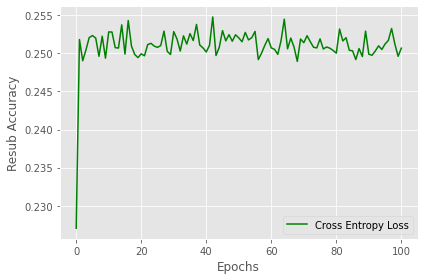

CPU times: user 1min 53s, sys: 10.3 s, total: 2min 3s
Wall time: 31.1 s


In [15]:
%%time 
nn_norm_onehot = TLPBetterInitial(**prm)
nn_norm_onehot.fit(X_train, y_train, print_progress=1)
print_result(nn_norm_onehot,X_train,y_train,X_test,y_test,title="Cross Entropy Loss",color="green")

Of the three models, the normalized one performed the best. The first model was quite inaccurate because of the high variation in feature data. Additionally, with the categorical data not encoded, the accuracy was far worse. Normalization helped address the high variation, which caused the greatest increase in accuracy between models. We figured that the addition of one-hot encoding for categorical data would increase the accuracy. However, we concluded that the neural network began to try and connect state and child poverty rate, since the state feature was one-hot encoded. While state and child poverty rate can be correlated, that is not necessarily a driving factor in each case, which was why the accuracy dropped. 

#### <br>*Use one-hot encoding and normalization on the dataset for the remainder of this lab assignment.*<br>

## Modeling

In [16]:
# [1 points] 
# Add support for a third layer in the multi-layer 
# perceptron. Add support for saving (and plotting after training
# is completed) the average magnitude of the gradient for 
# each layer, for each epoch. 

# For magnitude calculation, you are free to use either the
# average absolute values or the L1/L2 norm. Quantify the 
# performance of the model and graph the magnitudes for each 
# layer versus the number of epochs.

class MultiLayerPerceptron(object):   
    def __init__(self, n_layers=3, n_hidden=[30], 
                 C=0.0, epochs=500, eta=0.001, 
                 random_state=None, alpha=0.0, decrease_const=0.0,
                 shuffle=True, minibatches=1):
        np.random.seed(random_state)
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        
    @staticmethod
    def _encode_labels(y):
        """Onehot Encode the labels"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        W = []
        
        init_bound = 4*np.sqrt(6. / (self.n_hidden[0] + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden[0], self.n_features_ + 1))
        W1[:, :1] = 0
        W.append(W1)
        
        for i in range(self.n_layers - 2):
            init_bound = 4*np.sqrt(6 / (self.n_hidden[i + 1] + self.n_hidden[i] + 1))
            WTemp = np.random.uniform(-init_bound, init_bound,(self.n_hidden[i + 1], self.n_hidden[i] + 1))
            WTemp[:, :1] = 0
            W.append(WTemp)
        
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden[self.n_layers - 2] + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden[self.n_layers - 2] + 1))
        W2[:, :1] = 0
        W.append(W2)
        
        return W
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        total = 0
        for w in W:
            total += np.mean(w[:, 1:] ** 2)
        return (lambda_/2.0) * np.sqrt(total)
    
    def _feedforward(self, X, W):
        """Compute feedforward step"""
        A = []
        Z = []
        
        A1 = self._add_bias_unit(X, how='column')
        A1 = A1.T
        
        A.append(A1)
        
        for i in range(self.n_layers - 1):
            Z.append(W[i] @ A[i])
            Atemp = self._sigmoid(Z[i])
            Atemp = self._add_bias_unit(Atemp, how='row')
            A.append(Atemp)
            
        Z.append(W[len(W) - 1] @ A[len(A) - 1])
        A.append(self._sigmoid(Z[len(Z) - 1]))
            
        return A, Z
    
    #using cross entropy
    def _cost(self,A_final,Y_enc,W):
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A_final)+(1-Y_enc)*np.log(1-A_final))))
        L2_term = self._L2_reg(self.l2_C, W)
        return cost + L2_term

    #using cross entropy
    def _get_gradient(self, A, Z, Y_enc, W):
        grad = []
        V1 = (A[len(A) - 1] - Y_enc)
        V2 = V1
        grad_t = (V1 @ A[len(A) - 2].T)
        grad_t[:, 1:] += W[len(W) - 1][:, 1:] * self.l2_C
        grad.append(grad_t)
                
        for i in range(self.n_layers - 2):
            V = A[len(A) - i - 2]*(1 - A[len(A) - i - 2]) * (W[len(W) - i - 1].T @ V2)
            V2 = V[1:,:] 
            grad_t = V[1:,:] @ A[len(A) - i - 3].T
            grad_t[:, 1:] += W[len(W) - i - 2][:, 1:] * self.l2_C
            grad.insert(0, grad_t)
            
        V = A[1]*(1 - A[1]) * (W[1].T @ V2)
        grad_t = V[1:,:] @ A[0].T
        grad_t[:, 1:] += W[0][:, 1:] * self.l2_C
        grad.insert(0, grad_t)

        return grad
    
    def predict(self, X):
        """Predict class labels"""
        A, Z = self._feedforward(X, self.W)
        y_pred = np.argmax(A[len(A) - 1], axis=0)
        return y_pred
    
    #fit using mini batching
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W = self._initialize_weights()
        
        delta_W_prev = []
        for weight in self.W:
            delta_W_prev.append(np.zeros(weight.shape))

        self.cost_ = []
        self.score_ = []
        
        avg_grads = []
        for index in range(self.n_layers):
                avg_grads.append([])
        
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            grads = []
            for index in range(self.n_layers):
                grads.append(0)
            
            for idx in mini:

                # feedforward
                A, Z = self._feedforward(X_data[idx], self.W)
                
                cost = self._cost(A[len(A) - 1],Y_enc[:, idx],self.W)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad = self._get_gradient(A=A, Z=Z, Y_enc=Y_enc[:, idx], W=self.W)
                
                for index in range(len(grad)):
                    grads[index] += np.mean(grad[index])

                # momentum calculations
                delta_W = [g * self.eta for g in grad]
                
                for i in range(len(delta_W)):
                    self.W[i] -= (delta_W[i] + (self.alpha * delta_W_prev[i]))
                
                delta_W_prev = delta_W

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
            for index in range(len(avg_grads)):
                avg_grads[index].append(grads[index])
            
        return avg_grads
    

In [17]:
import matplotlib.pyplot as plt

def print_result(nn,X_train,y_train,X_test,y_test,grads,title="",color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')
    
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    
    for index in range(len(grads)):
        plt.plot(range(len(grads[0])), grads[index], label="grad_"+str(index + 1))
    
    plt.ylabel('Average Magnitude of the Gradient')
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

Epoch: 100/100

Cross Entropy Loss :
Resubstitution acc: 0.7408120466187644
Validation acc: 0.7315044004400441


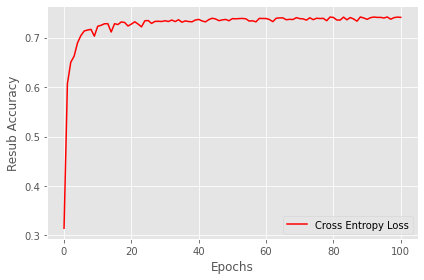

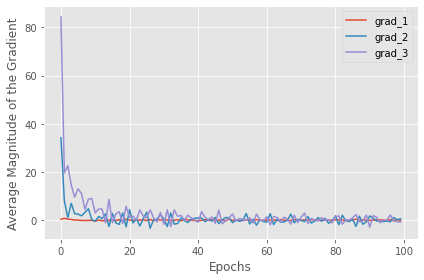

CPU times: user 1min 12s, sys: 4.66 s, total: 1min 17s
Wall time: 19.4 s


In [18]:
%%time 

vals = { 'n_layers':3, 'n_hidden':[30, 25], 
         'C':0.1, 'epochs':100, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}

nn_3 = MultiLayerPerceptron(**vals)

grads = nn_3.fit(X_train, y_train, print_progress=1)
print_result(nn_3, X_train, y_train,
             X_test, y_test, grads,
             title="Cross Entropy Loss",color="red")

Epoch: 100/100

Cross Entropy Loss :
Resubstitution acc: 0.7425310276068346
Validation acc: 0.7343921892189219


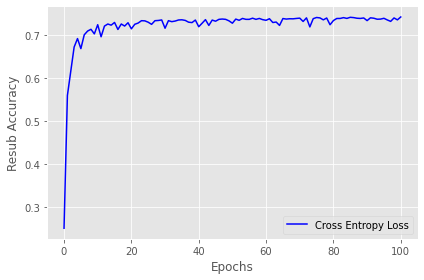

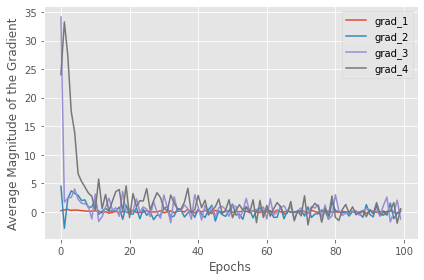

CPU times: user 1min 34s, sys: 6.77 s, total: 1min 41s
Wall time: 25.6 s


In [19]:
%%time 

# [1 points] 
# Repeat the previous step, adding support for a 
# fourth layer
vals = dict(n_layers=4, n_hidden=[30, 25, 20], 
            C=0.1, epochs=100, eta=0.001, 
            alpha=0.001, decrease_const=1e-5, minibatches=50,
            shuffle=True,random_state=1)

nn_4 = MultiLayerPerceptron(**vals)
grads = nn_4.fit(X_train, y_train, print_progress=1)
print_result(nn_4, X_train, y_train,
             X_test, y_test, grads,
             title="Cross Entropy Loss",color="blue")


Epoch: 100/100

Cross Entropy Loss :
Resubstitution acc: 0.7428232543748066
Validation acc: 0.7334983498349835


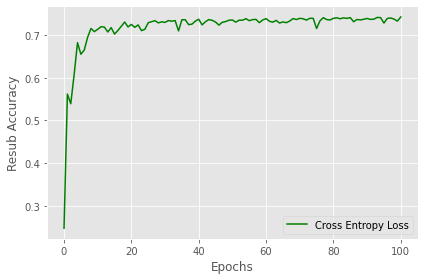

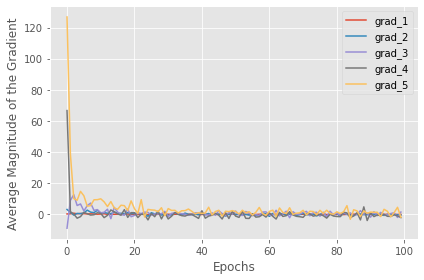

CPU times: user 1min 51s, sys: 9.01 s, total: 2min
Wall time: 30.4 s


In [20]:
%%time

# [1 points]
# Repeat the previous step, adding support for a
# fifth layer.
vals = dict(n_layers=5, n_hidden=[30, 25, 20, 15], 
            C=0.1, epochs=100, eta=0.001, 
            alpha=0.001, decrease_const=1e-5, minibatches=50,
            shuffle=True,random_state=1)

nn_5 = MultiLayerPerceptron(**vals)
grads = nn_5.fit(X_train, y_train, print_progress=1)
print_result(nn_5, X_train, y_train,
             X_test, y_test, grads,
             title="Cross Entropy Loss",color="green")

In [21]:
# [2 points] 
# Implement an adaptive learning technique that was
# discussed in lecture and use it on the five layer network. 
# Compare the performance of this model with and without the 
# adaptive learning strategy. Do not use AdaM for the adaptive
# learning technique. 

class MultiLayerPerceptronNoAdaptive(MultiLayerPerceptron):
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W = self._initialize_weights()

        self.cost_ = []
        self.score_ = []
        
        avg_grads = []
        for index in range(self.n_layers):
                avg_grads.append([])
        
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            grads = []
            for index in range(self.n_layers):
                grads.append(0)
            
            for idx in mini:

                # feedforward
                A, Z = self._feedforward(X_data[idx], self.W)
                
                cost = self._cost(A[len(A) - 1],Y_enc[:, idx],self.W)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad = self._get_gradient(A=A, Z=Z, Y_enc=Y_enc[:, idx], W=self.W)
                
                for index in range(len(grad)):
                    grads[index] += np.mean(grad[index])

                delta_W = [g * self.eta for g in grad]
                
                for i in range(len(delta_W)):
                    self.W[i] -= delta_W[i]
                

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
            for index in range(len(avg_grads)):
                avg_grads[index].append(grads[index])
            
        return avg_grads


Epoch: 100/100

Cross Entropy Loss :
Resubstitution acc: 0.7429607728538522
Validation acc: 0.732948294829483


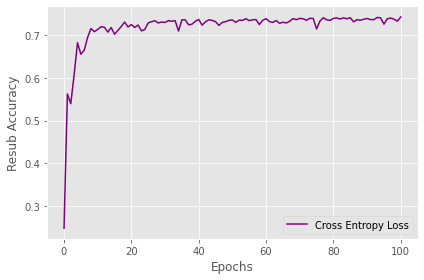

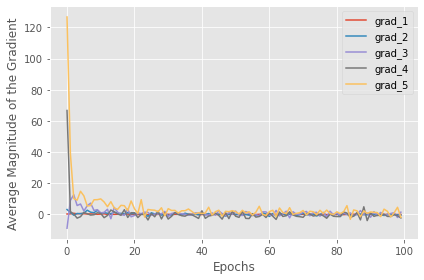

CPU times: user 1min 45s, sys: 7.46 s, total: 1min 53s
Wall time: 28.5 s


In [22]:
%%time

vals = dict(n_layers=5, n_hidden=[30, 25, 20, 15], 
            C=0.1, epochs=100, eta=0.001, 
            alpha=0.001, decrease_const=1e-5, minibatches=50,
            shuffle=True,random_state=1)

nn_5 = MultiLayerPerceptronNoAdaptive(**vals)
grads = nn_5.fit(X_train, y_train, print_progress=1)
print_result(nn_5, X_train, y_train,
             X_test, y_test, grads,
             title="Cross Entropy Loss",color="purple")

The neural network without the adaptive learning is just slightly worse than that with an adaptive learning rate. They also take about the same time to execute, so there is no time efficiency sacrifice for the slightly increased accuracy.

## Exceptional Work
Taking late penalty.